In [1]:
# Basic imports
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
years = list(range(1991, 2023)) # Years from 1991 season to 2022 season

In [3]:
# Get the MVP Candidates for each year.
for year in years: # Parses through each year
    mvp_url = f"https://www.basketball-reference.com/awards/awards_{year}.html" # MVP URL for each year
    response = requests.get(mvp_url) # Response from URL
    with open (f"MVPS/mvp_list_{year}.html", "w") as file:
        file.write(response.text) # Copy everything into local directory

In [6]:
mvp_data_list = [] # Will store all NBA MVP Lists
for year in years: # Parses through each year
    with open (f"MVPS/mvp_list_{year}.html") as file:
        data = file.read() # Opens all Files
    soup = BeautifulSoup(data, 'html.parser') # Using beautiful soup to scrape
    soup.find('tr', class_="over_header").decompose() # Removes unnecessary table row
    table = soup.find_all(id="mvp")[0] # Gets the MVP Table
    mvp_data = pd.read_html(str(table))[0] # Pandas reads it
    mvp_data["Year"] = year # Add a column for year to tell the time period
    mvp_data_list.append(mvp_data) # Adds dataframes to the NBA MVP List
all_mvps = pd.concat(mvp_data_list) # Combines all the MVP data into one frame
all_mvps.to_csv("mvps.csv")

In [7]:
# Get the Player Stats for each year with Selenium.
# Selenium is needed in order to select options on NBA-References for precise data
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
chrome_options = Options()
chrome_options.add_experimental_option("detach", True)
s = Service("/Users/pirani/Desktop/chromedriver")
driver = webdriver.Chrome(service=s, options=chrome_options)

for year in years:
    stats_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
    driver.get(stats_url)
    driver.execute_script("window.scrollTo(1,500)")
    time.sleep(1)
    toggle_button = driver.find_element(By.ID, "per_game_stats_toggle_partial_table")
    toggle_button.click()
    with open (f"PLAYERS/players_stats_{year}.html", "w") as file:
        file.write(driver.page_source)

In [8]:
# Player Stats Dataframe
player_stats_list = []
for year in years:
    with open (f"PLAYERS/players_stats_{year}.html") as file:
        data = file.read()
    soup = BeautifulSoup(data, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    table = soup.find_all(id="per_game_stats")[0]
    player_data = pd.read_html(str(table))[0]
    player_data["Year"] = year
    player_stats_list.append(player_data)
all_players = pd.concat(player_stats_list) # Combines all the Player data into one frame
all_players.to_csv("player_stats_list.csv")

In [9]:
# Get Team Statistics
for year in years:
    teams_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html"
    response = requests.get(teams_url)
    with open (f"TEAMS/teams_list_{year}.html", "w") as file:
        file.write(response.text)

In [11]:
# Team Statistics Dataframe
teams_stats_list = []
for year in years:
    with open (f"TEAMS/teams_list_{year}.html") as file:
        data = file.read()
    soup = BeautifulSoup(data, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    eastern_table = soup.find_all(id="divs_standings_E")[0]
    eastern_data = pd.read_html(str(eastern_table))[0]
    eastern_data["Year"] = year
    eastern_data["Team"] = eastern_data["Eastern Conference"]
    
    western_table = soup.find_all(id="divs_standings_W")[0]
    western_data = pd.read_html(str(western_table))[0]
    western_data["Year"] = year
    western_data["Team"] = western_data["Western Conference"]
    
    del western_data["Western Conference"]
    del eastern_data["Eastern Conference"]
    teams_stats_list.append(eastern_data)
    teams_stats_list.append(western_data)
team_stats = pd.concat(teams_stats_list)    
team_stats.to_csv("teams.csv")

In [12]:
# Data Cleaning for MVP Data
mvps = pd.read_csv("mvps.csv")
mvps = mvps[["Player", "Year", "Pts Won", "Pts Max", "Share"]] # These are only the necessary columns we need
mvps.head(5)

,Player,Year,Pts Won,Pts Max,Share
0,Michael Jordan,1991,891.0,960,0.928
1,Magic Johnson,1991,497.0,960,0.518
2,David Robinson,1991,476.0,960,0.496
3,Charles Barkley,1991,222.0,960,0.231
4,Karl Malone,1991,142.0,960,0.148


In [13]:
# Data Cleaning for Player Data
players = pd.read_csv("player_stats_list.csv")
del players["Rk"]
del players["Unnamed: 0"]
players["Player"] = players["Player"].str.replace("*","", regex=False)
players.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,.474,...,0.6,1.4,2.1,0.3,0.1,0.3,0.5,0.9,3.1,1991
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,.413,...,0.5,1.3,1.8,3.1,0.8,0.1,1.6,2.2,14.1,1991
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,.509,...,2.1,3.2,5.3,0.4,0.4,0.4,0.6,3.2,4.2,1991
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,.394,...,0.9,3.0,3.9,10.5,2.2,0.1,3.6,2.5,26.5,1991
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,.462,...,1.7,3.1,4.8,1.8,0.6,0.3,1.6,2.7,14.2,1991


In [14]:
# Merging Player and MVP Data into one.
merger = players.merge(mvps, how="outer", on=["Player", "Year"])
merger[["Pts Won", "Pts Max", "Share"]] = merger[["Pts Won", "Pts Max", "Share"]].fillna(0)
merger

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,Alaa Abdelnaby,PF,22,POR,43,0,6.7,1.3,2.7,.474,...,0.3,0.1,0.3,0.5,0.9,3.1,1991,0.0,0.0,0.0
1,Mahmoud Abdul-Rauf,PG,21,DEN,67,19,22.5,6.2,15.1,.413,...,3.1,0.8,0.1,1.6,2.2,14.1,1991,0.0,0.0,0.0
2,Mark Acres,C,28,ORL,68,0,19.3,1.6,3.1,.509,...,0.4,0.4,0.4,0.6,3.2,4.2,1991,0.0,0.0,0.0
3,Michael Adams,PG,28,DEN,66,66,35.5,8.5,21.5,.394,...,10.5,2.2,0.1,3.6,2.5,26.5,1991,0.0,0.0,0.0
4,Mark Aguirre,SF,31,DET,78,13,25.7,5.4,11.7,.462,...,1.8,0.6,0.3,1.6,2.7,14.2,1991,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18880,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,.465,...,1.7,1.2,0.4,0.8,1.7,6.3,2022,0.0,0.0,0.0
18881,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,.460,...,9.7,0.9,0.1,4.0,1.7,28.4,2022,0.0,0.0,0.0
18882,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,.526,...,0.9,0.3,0.4,0.7,1.5,5.3,2022,0.0,0.0,0.0
18883,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,.567,...,0.8,0.3,0.2,0.7,2.1,5.2,2022,0.0,0.0,0.0


In [15]:
# Data Cleaning for Team Data.
teams = pd.read_csv("teams.csv")
teams = teams[~teams.Team.str.contains("Division")]
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)
del teams["Unnamed: 0"]

In [17]:
# Fixes the "Team" column in order to merge data
team_map = {}
with open("abbreviation.txt") as file:
    data = file.readlines()
    for i in data:
        i.replace("\n", "")
        abbreviated, team = i.replace("\n", "").split(",")
        team_map[team] = abbreviated
teams.replace({"Team": team_map},inplace=True)
teams.rename(columns= {'Team':'Tm'}, inplace = True)

In [18]:
# Merges the Team and Player/MVP Data
training_set = merger.merge(teams, how="outer", on=["Tm", "Year"])
training_set = training_set.dropna()
training_set = training_set.apply(pd.to_numeric, errors='ignore')
training_set["GB"] = pd.to_numeric(training_set["GB"].str.replace("—","0"))
training_set.fillna(0)
team_stats.to_csv("teams.csv")
training_set.to_csv("completed_data.csv")
data = pd.read_csv("completed_data.csv", index_col=0)

<AxesSubplot:>

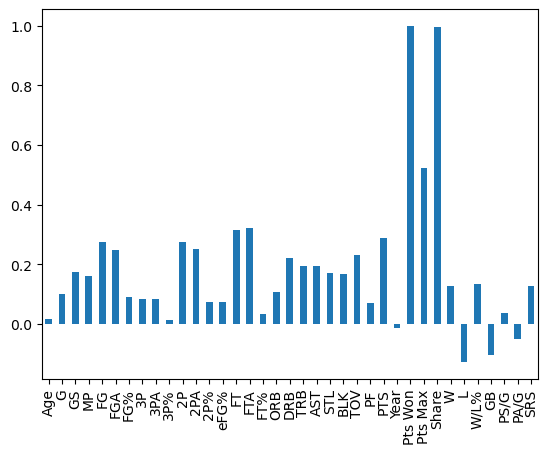

In [19]:
data.corr()["Pts Won"].plot.bar() # Free Throw Attemps correlate highly to points won.

In [44]:
# Predictions and Train,Test variables
predictors = ["Age", "G", "GS", "MP", "FG", "FGA", 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W', 'L', 'W/L%','GB', 'PS/G', 'PA/G', 'SRS']
train = data[~(data["Year"] == 2022)]
test = data[data["Year"] == 2022]

In [45]:
# XGBoost Regressor Implementation
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(train[predictors], train["Share"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [58]:
# Predicting with XGBoost and comparing with actual values
predict = regressor.predict(test[predictors])
predict = pd.DataFrame(predict, columns=["Predicted Share"], index=test.index)

combo = pd.concat([test[["Player", "PTS", "TRB", "AST", "W/L%", "Share"]], predict], axis=1)
combo.sort_values("Predicted Share", ascending=False).head(5)

ranking = combo.sort_values("Share", ascending=False)
predicted_ranking = combo.sort_values("Predicted Share", ascending=False)
ranking["Rank"] = list(range(1,ranking.shape[0]+1))
predicted_ranking["Predicted Rank"] = list(range(1,predicted_ranking.shape[0]+1))

cols_to_use = predicted_ranking.columns.difference(ranking.columns)
output = pd.merge(ranking, predicted_ranking[cols_to_use], left_index=True, right_index=True, how='outer')
#output.sort_values("Share", ascending=False).head(5)
output = output.sort_values("Share", ascending=False)
output.head(5)

,Player,PTS,TRB,AST,W/L%,Share,Predicted Share,Rank,Predicted Rank
18635,Nikola Jokić,27.1,13.8,7.9,0.585,0.875,0.447122,1,3
18648,Joel Embiid,30.6,11.7,4.2,0.622,0.706,0.481625,2,2
18280,Giannis Antetokounmpo,29.9,11.6,5.8,0.622,0.595,0.330945,3,5
18483,Devin Booker,26.8,5.0,4.8,0.780,0.216,0.707937,4,1
18796,Luka Dončić,28.4,9.1,8.7,0.634,0.146,0.164990,5,7


In [66]:
# Error Metric for Top 5
from sklearn.metrics import mean_absolute_error

actual = list(output["Rank"].head(5))
predicted = list(output["Predicted Rank"].head(5))

error = mean_absolute_error(actual, predicted)
print("Mean absolute error : " + str(error))

Mean absolute error : 1.8


In [115]:
# Predicting 2023 MVP with XGBoost
from xgboost import XGBRegressor
data_2023 = pd.read_csv("2023_Predict/completed_data_2023.csv", index_col=0)
data_2023.dropna()
predictors_2023 = ["Age", "MP", "FG", "FGA", 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W/L%', 'PS/G', 'PA/G', 'SRS']

train_2023 = data[~(data["Year"] == 2022)]
test_2023 = data_2023

regressor_2023 = XGBRegressor()
regressor_2023.fit(train_2023[predictors_2023], train_2023["Share"])

predict_2023 = regressor_2023.predict(test_2023[predictors_2023])
predict_2023 = pd.DataFrame(predict_2023, columns=["Predicted Share"], index=test_2023.index)

combo_2023 = pd.concat([test_2023[["Player", "PTS", "TRB", "AST", "W/L%"]], predict_2023], axis=1)
combo_2023.sort_values("Predicted Share", ascending=False).head(10)

,Player,PTS,TRB,AST,W/L%,Predicted Share
451,Jayson Tatum,31.1,8.3,4.3,0.733,0.915971
441,Jaylen Brown,27.2,7.1,3.2,0.733,0.791983
28,Ja Morant,27.5,5.7,7.9,0.698,0.617365
472,Joel Embiid,33.4,9.8,4.3,0.628,0.604780
321,Luka Dončić,33.8,9.0,8.8,0.533,0.503408
431,Nikola Jokić,24.7,10.9,9.8,0.698,0.487462
66,Giannis Antetokounmpo,31.0,11.9,5.3,0.636,0.431293
112,Zion Williamson,26.0,7.0,4.6,0.591,0.244454
381,Tyrese Haliburton,20.2,4.0,10.2,0.511,0.237992
88,Donovan Mitchell,28.4,3.9,4.8,0.622,0.218291
